In [0]:
# create a notebook for LSTM prediction model 

# 1. Load the chosen dataset and try to see the vocab size 
# 2. Determine a MAX_VOCAB_SIZE incase you observe a vocab dict that is too large (choose the top/most frequent MAX_VOCAB_SIZE entries / Curse of dimensionality)
# 3. Determine a MAX_SEQUENCE LENGTH to vectorize for each review (Note: From splitter usually reviews will be limited to 400 + summary )

# DO NOT EDIT/ DELETE THIS BLOCK;



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# set working directory -> you must set the path into which you have uploaded the zipped file
# this is required in the case of colab or local 
%cd /content/drive/My\ Drive/SNLP\ Project
# %cd Source/repos/Sentiment-Analysis-using-Deep-Learning

/content/drive/My Drive/SNLP Project


In [24]:
# list content of drive - verify you are where you are supposed to be
%ls

 amz_all_beauty/                    model.png
 amz_all_electronics/               ModelResults/
 CleantData_Apr-03-2020_01-31.zip  'Project Ideas.gdoc'
 Electronics_5.json.gz             'Project Proposal.gdoc'
 Lexical_analysis/                 'Report MetaData'/


In [14]:
# load your choice of dataset here . Specify paths as folder_datestring/file_datestring.zip
Train_ZipCSVFileName = 'amz_all_electronics/Data_Balanced_2000_Apr-03-2020_06-46/Train_2000_Apr-03-2020_06-46.zip'
Test_ZipCSVFileName = 'amz_all_electronics/Data_Balanced_2000_Apr-03-2020_06-46/Test_2000_Apr-03-2020_06-46.zip'

import pandas as pd
import numpy as np


df_train = pd.read_csv(Train_ZipCSVFileName)
df_train.info()

df_test = pd.read_csv(Test_ZipCSVFileName)
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         10000 non-null  float64
 1   reviewTime      10000 non-null  object 
 2   reviewerID      10000 non-null  object 
 3   asin            10000 non-null  object 
 4   reviewText      10000 non-null  object 
 5   summary         10000 non-null  object 
 6   unixReviewTime  10000 non-null  int64  
 7   reviewText_len  10000 non-null  int64  
 8   summary_len     10000 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 703.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         1000 non-null   float64
 1   reviewTime      1000 non-null   object 
 2   reviewerID      1000 non-null   object 
 3  

In [15]:

# Get names of indexes for which column Age has value 30
index_neutrals_train = df_train[ df_train['overall'] == 3 ].index
index_neutrals_test = df_test[ df_test['overall'] == 3 ].index
 
# Delete these row indexes from dataFrame
df_train.drop(index_neutrals_train , inplace=True)
df_test.drop(index_neutrals_test , inplace=True)

df_train.loc[(df_train.overall == 1),'overall']= 1
df_train.loc[(df_train.overall == 2),'overall']= 1
df_train.loc[(df_train.overall == 4),'overall']= 5
df_train.loc[(df_train.overall == 5),'overall']= 5

df_test.loc[(df_test.overall == 1),'overall']= 1
df_test.loc[(df_test.overall == 2),'overall']= 1
df_test.loc[(df_test.overall == 4),'overall']= 5
df_test.loc[(df_test.overall == 5),'overall']= 5

df_train['reviewText_len'].describe()
# Since the mean average review size is around 145 chars and max is 400, I can safely set the max [summary + review] Text Limit to 400 
	

count    8000.000000
mean      146.234875
std       109.121888
min         1.000000
25%        47.000000
50%       127.000000
75%       223.250000
max       399.000000
Name: reviewText_len, dtype: float64

In [16]:
df_train['overall'].describe()
df_test['summary_len'].describe()

count    800.000000
mean      14.950000
std        8.001408
min        2.000000
25%        9.000000
50%       11.000000
75%       20.000000
max       34.000000
Name: summary_len, dtype: float64

In [0]:
# The maximum number of words to be used. (most frequent)
MAX_VOCAB_SIZE = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 200

import uuid
folderGUID = uuid.uuid4().hex

# stupid shell way of converting variable to string 
!mkdir "ModelResults/v3_$folderGUID"

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [19]:
tokenizer = Tokenizer(num_words= MAX_VOCAB_SIZE, filters='#$%&()*+<=>@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(df_train['reviewText'] + ' DELIM '+df_train['reviewText'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7884 unique tokens.


In [25]:

print(df_train['summary'].values + ' DELIM '+ df_train['reviewText'].values)

['do not buy DELIM did not work im sure the seller knew this befor he ship it out date and cannot be use at all those are word from the manufactur'
 'one star DELIM real garbag dont wast your money'
 'one star DELIM did not work' ... 'five star DELIM did the job'
 'perfect DELIM perfect' 'work DELIM work fix my truck skip cd player']


In [20]:
X = tokenizer.texts_to_sequences(df_train['summary'].values + ' DELIM '+ df_train['reviewText'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (8000, 250)


In [21]:
Y = pd.get_dummies(df_train['overall']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (8000, 2)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(200, dropout = 0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# run for small number of epochs then save 
epochs = 3

history = model.fit(X, Y, epochs=epochs)

Epoch 1/3
250/250 [==============================] - 187s 748ms/step - loss: 0.3750 - accuracy: 0.8314
Epoch 2/3
250/250 [==============================] - 185s 741ms/step - loss: 0.1365 - accuracy: 0.9511
Epoch 3/3
250/250 [==============================] - 186s 742ms/step - loss: 0.0796 - accuracy: 0.9730


In [30]:
# Save the model to Local Disk 
# https://stackoverflow.com/questions/45424683/how-to-continue-training-for-a-saved-and-then-loaded-keras-model

filePath = "ModelResults/v3_"+str(folderGUID)+"/model.h5"
model.save(filePath)
print("Saved model to disk : "+ str(folderGUID))



Saved model to disk : 767c02af219c4133946edcaf89e67387


In [28]:
# Run additional training if necessary & remember to resave it 
#from tensorflow.keras.models import load_model
#filePath = 'ModelResults/5eab2088768f4439824f997f86e64122/model.h5'
# Load the model
#model = load_model(filePath)

# Train more on the loaded model
history = model.fit(X, Y, epochs=epochs)



Epoch 1/3
250/250 [==============================] - 186s 745ms/step - loss: 0.0419 - accuracy: 0.9868
Epoch 2/3
250/250 [==============================] - 191s 766ms/step - loss: 0.0407 - accuracy: 0.9881
Epoch 3/3
250/250 [==============================] - 188s 750ms/step - loss: 0.0175 - accuracy: 0.9948


In [29]:


X_test = tokenizer.texts_to_sequences(df_test['reviewText'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Y_Test = pd.get_dummies(df_test['overall']).values
print('Shape of label tensor:', Y_Test.shape)

accr = model.evaluate(X_test,Y_Test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Shape of data tensor: (800, 250)
Shape of label tensor: (800, 2)
25/25 [==============================] - 5s 203ms/step - loss: 0.6576 - accuracy: 0.8350
Test set
  Loss: 0.658
  Accuracy: 0.835


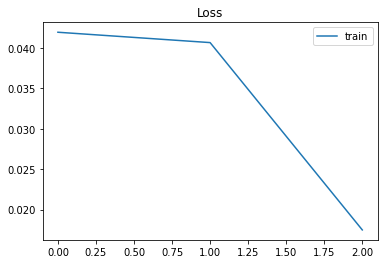

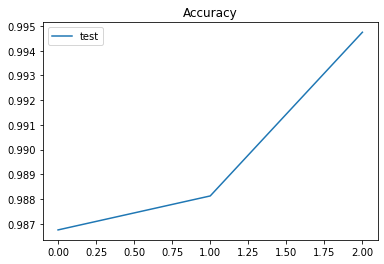

In [35]:
import matplotlib.pyplot as plt


plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='test')
plt.legend()
plt.show();


In [14]:
# Test for single review 
new_review = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)


print(pred)
print(np.argmax(pred))

[[0.96999913 0.03000082]]
0


In [0]:
# VISUALIZE THE EMBEDDINGS
from sklearn.manifold import TSNE
import plotly.offline as plotly
import plotly.graph_objs as pltgo
#plotly.init_notebook_mode(connected = True)

words = [] 
for word, i in tokenizer.word_index.items():
  words.append(word)

def plot_words(data, start, stop, step):
  trace = pltgo.Scatter(
      x = data[start:stop:step,0],
      y = data[start:stop:step,1],
      mode = 'markers',
      text = words[start:stop:step]
  )
  layout = dict(title = 't-SNE 1 vs t-SNE 2',
                yaxis = dict(title = 't-SNE 2'),
                xaxis = dict(title = 't-SNE 1'),
                hovermode = 'closest')
  fig = dict(data=[trace], layout = layout)
  pyotly.iplot(fig)  

model_embeddings = model.layers[0].get_weights()[0]
lstm_embeds = TSNE(n_components =2, verbose=10).fit_transform(model_embeddings)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 1.466s...


In [1]:
plot_words(lstm_embeds, 0, MAX_VOCAB_SIZE, 1)

NameError: ignored